In [1]:
# import the relevant packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow import keras
from tensorflow.keras import layers

from helper_functions.scan_helper_functions import train_forward_model, load_dataset, build_forward_surrogate, calculate_metrics
from helper_functions.scan_helper_functions import calculate_metrics

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [2]:
import ray 
from ray import tune

# Load and prepare the data

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [4]:
datafile = directory +'/aerosol_data/phase_data.hdf5'


In [5]:
dvar_train, dvar_val, dvar_test, qoi_train, qoi_val, qoi_test = load_dataset(datafile)
dvar_train.T[2] = dvar_train.T[2]*1.e+08
dvar_val.T[2] = dvar_val.T[2]*1.e+08
dvar_test = np.array(dvar_test)
dvar_test.T[2] =dvar_test.T[2]*1.e+08
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
#dvar_train = min_max_scaler.fit_transform(dvar_train)
#dvar_val = min_max_scaler.fit_transform(dvar_val)
#dvar_test = min_max_scaler.fit_transform(dvar_test)



qoi_train = min_max_scaler.fit_transform(qoi_train)
qoi_val = min_max_scaler.fit_transform(qoi_val)
qoi_test = min_max_scaler.fit_transform(qoi_test)
    

    
train_data = [dvar_train,qoi_train]
val_data = [dvar_val,qoi_val]
test_data = [dvar_test,qoi_test]


In [6]:
dvar_test

array([[1.00000000e-01, 2.00000000e+00, 1.00000000e+00, 1.47000000e+00,
        3.15478672e-03],
       [1.50000000e+00, 1.50000000e+00, 1.00000000e+00, 1.52000000e+00,
        3.15478672e-03],
       [3.00000000e-01, 1.90000000e+00, 1.00000000e+00, 1.48000000e+00,
        1.99053585e-03],
       ...,
       [3.00000000e-01, 1.50000000e+00, 1.00000000e+00, 1.39000000e+00,
        1.99053585e-03],
       [9.00000000e-01, 1.30000000e+00, 1.00000000e+00, 1.57000000e+00,
        5.00000000e-02],
       [1.50000000e+00, 1.60000000e+00, 1.00000000e+00, 1.51000000e+00,
        5.00000000e-02]])

In [6]:
dvar_train

array([[0.7       , 1.4       , 1.        , 1.49      , 0.05      ],
       [1.1       , 1.4       , 1.        , 1.51      , 0.19905359],
       [0.9       , 2.        , 1.        , 1.39      , 0.19905359],
       ...,
       [1.3       , 1.3       , 1.        , 1.44      , 0.01255943],
       [0.7       , 1.2       , 1.        , 1.56      , 0.31547867],
       [1.9       , 1.3       , 1.        , 1.46      , 0.12559432]])

In [7]:
# create some data to test the linear regression
test_methods_x, test_methods_y = make_regression(n_samples=1000, n_features=10, n_informative=5,n_targets=2,random_state=1,noise=0.5)
print(test_methods_x.shape)
print(test_methods_y.shape)
test_methods_x_train,test_methods_x_test, test_methods_y_train, test_methods_y_test=train_test_split(test_methods_x,test_methods_y, test_size=0.33,random_state=42)

(1000, 10)
(1000, 2)


# Design the Autoencoder

# Test Autoencoder with customized loss function

In [8]:
for size in range(5):
    print(size)

0
1
2
3
4


In [9]:
class Autoencoder(Model):
    def __init__(self,qoi_dim, dvar_dim, alpha, n_encode_layers, n_decode_layers):
        super(Autoencoder,self).__init__()
        self.qoi_dim = qoi_dim
        self.dvar_dim = dvar_dim
        self.alpha = alpha
        self.n_encode_layers = n_encode_layers
        self.n_decode_layers = n_decode_layers
        
        layers = [tf.keras.layers.Input(shape=dvar_dim[1])]
        for size in range(n_encode_layers):
            layers.append(tf.keras.layers.Dense(qoi_dim[1], activation='sigmoid'))
        layers.append(tf.keras.layers.Dense(qoi_dim[1]))
        self.encoder = tf.keras.models.Sequential(layers)
        
        layers = [tf.keras.layers.Input(shape=qoi_dim[1])]
        for size in range(n_decode_layers):
            layers.append(tf.keras.layers.Dense(qoi_dim[1], activation='sigmoid'))
        layers.append(tf.keras.layers.Dense(dvar_dim[1]))
        self.decoder = tf.keras.models.Sequential(layers)
         
        

    def call(self,x):
        dvar = x[0]
        print(dvar)
        qoi = x[1]
        encoded = self.encoder(dvar)
        decoded = self.decoder(encoded)
        dvar_diff = tf.math.add(dvar,-decoded)
        dvar_loss = tf.math.reduce_sum(tf.math.square(dvar_diff))/dvar.shape[1]       
        qoi_diff = tf.math.add(qoi,-encoded)
        qoi_loss = tf.math.reduce_sum(tf.math.square(qoi_diff))/qoi.shape[1]
        sum_loss = tf.math.add(dvar_loss, self.alpha *qoi_loss)
        self.add_loss(sum_loss )
        return decoded

In [106]:
def train_autoencoder(config):
    datafile = config['datafile']
    dvar_train, dvar_val, dvar_test, qoi_train, qoi_val, qoi_test = load_dataset(datafile)
    dvar_train.T[2] = dvar_train.T[2]*1.e+08
    dvar_val.T[2] = dvar_val.T[2]*1.e+08
    dvar_test = np.array(dvar_test)
    dvar_test.T[2] =dvar_test.T[2]*1.e+08
    #Preprocess data
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    #dvar_train = min_max_scaler.fit_transform(dvar_train)
    #dvar_val = min_max_scaler.fit_transform(dvar_val)
    #dvar_test = min_max_scaler.fit_transform(dvar_test)
    qoi_train = min_max_scaler.fit_transform(qoi_train)
    qoi_val = min_max_scaler.fit_transform(qoi_val)
    qoi_test = min_max_scaler.fit_transform(qoi_test)
    
    
    alpha = config['alpha']
    learning_rate = config['learning_rate']
    n_encode_layers = config['n_encode_layers']
    n_decode_layers = config['n_decode_layers']
    epochs = 10
    
    train_data = [dvar_train,qoi_train]
    val_data = [dvar_val,qoi_val]
    test_data = [dvar_test,qoi_test]
    
    autoencoder = Autoencoder(qoi_train.shape ,dvar_train.shape, alpha, n_encode_layers, n_decode_layers)
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate))
    # Train
    history_loss = autoencoder.fit(train_data, train_data, 
                epochs = epochs,
                batch_size = qoi_train.shape[0],
                #batch_size = 32,    
                validation_data = (val_data,val_data))
    # save the model
#     autoencoder.save(tune.get_trial_dir())
  #  history_loss = pd.DataFrame(history_loss.history)
  #  hist_csv_file = 'path'+'history_loss.csv'

   # history_df.to_csv(history_csv_file,index = False)
    dvar_pred_train1 = autoencoder.predict(train_data)
    dvar_pred_val1 = autoencoder.predict(val_data)

    dvar_pred_train2 = autoencoder.decoder(qoi_train)
    dvar_pred_val2 = autoencoder.decoder(qoi_val)

    qoi_pred_train1 = autoencoder.encoder(dvar_train)
    qoi_pred_val1 = autoencoder.encoder(dvar_val)

    metrics_train_dvar1 = calculate_metrics(dvar_pred_train1, dvar_train,n_in = dvar_train.shape[1])
    metrics_train_dvar2 = calculate_metrics(dvar_pred_train2, dvar_train,n_in = dvar_train.shape[1])
    metrics_train_qoi1 = calculate_metrics(qoi_pred_train1, qoi_train,n_in = qoi_train.shape[1])

    metrics_val_dvar1 = calculate_metrics(dvar_pred_val1, dvar_val,n_in = dvar_train.shape[1])
    metrics_val_dvar2 = calculate_metrics(dvar_pred_val2, dvar_val,n_in = dvar_train.shape[1])
    metrics_val_qoi1 = calculate_metrics(qoi_pred_val1, qoi_val,n_in = qoi_train.shape[1])

    metrics = {}

    for key in metrics_train_dvar1.keys():
        metrics[f'{key}_train_dvar1'] = metrics_train_dvar1[key]
        metrics[f'{key}_train_dvar2'] = metrics_train_dvar2[key]
        metrics[f'{key}_train_qoi1'] = metrics_train_qoi1[key]
        metrics[f'{key}_val_dvar1'] = metrics_val_dvar1[key]
        metrics[f'{key}_val_dvar2'] = metrics_val_dvar2[key]
        metrics[f'{key}_val_qoi1'] = metrics_val_qoi1[key]
        
    return autoencoder, history, metrics_train_dvar1, metrics_train_dvar2, metrics_train_qoi1,metrics_val_dvar1, metrics_val_dvar2, metrics_val_qoi1
        #tune.report(**metrics)

In [11]:
def calculate_metrics_new(qoi_true,qoi_pred, n_in):
    
    qoi_true = np.array(qoi_true)
    qoi_pred = np.array(qoi_pred)
    abs_residuals = np.abs(qoi_true - qoi_pred)
    rel_residuals = np.abs(abs_residuals / qoi_true) * 100.

    maximum_percentage_error = np.max(rel_residuals, axis=1)
    median = np.quantile(maximum_percentage_error, 0.5)
    ninety_percentile = np.quantile(maximum_percentage_error, 0.9)
    
    mean_true = np.mean(qoi_true,axis=0)
    total_sum_of_squares = np.sum((qoi_true-mean_true)**2.,axis=0)
    residual_sum_of_squares = np.sum((qoi_true - qoi_pred)**2.,axis = 0)
    r2 = 1. - residual_sum_of_squares / total_sum_of_squares
    return {
        'MAE': np.mean(abs_residuals),
        'MAPE': np.mean(rel_residuals),
        'median_percentile_max_error': median,
        '90_percentile_max_error': ninety_percentile,
        'r2': r2,
    }

In [12]:
config = {'datafile':datafile,
          'alpha': 1,
          'learning_rate': 0.01,
          'n_encode_layers': 10,
          'n_decode_layers':10
        }

In [107]:
autoencoder, history, metrics_train_dvar1, metrics_train_dvar2, metrics_train_qoi1,metrics_val_dvar1, metrics_val_dvar2, metrics_val_qoi1 = train_autoencoder(config)

Epoch 1/1000
Tensor("IteratorGetNext:0", shape=(25344, 5), dtype=float64)
Tensor("IteratorGetNext:0", shape=(25344, 5), dtype=float64)
1/1 [==============================] - 0s 241ms/step - loss: 88207.4045 - val_loss: 7021.9124
Epoch 2/1000
1/1 [==============================] - 0s 97ms/step - loss: 28069.4638 - val_loss: 9014.7904
Epoch 3/1000
1/1 [==============================] - 0s 88ms/step - loss: 36266.1524 - val_loss: 4551.0882
Epoch 4/1000
1/1 [==============================] - 0s 94ms/step - loss: 18355.5788 - val_loss: 1661.6327
Epoch 5/1000
1/1 [==============================] - 0s 96ms/step - loss: 6659.1676 - val_loss: 1914.0334
Epoch 6/1000
1/1 [==============================] - 0s 89ms/step - loss: 7544.6305 - val_loss: 3040.5790
Epoch 7/1000
1/1 [==============================] - 0s 94ms/step - loss: 11983.3638 - val_loss: 3403.4079
Epoch 8/1000
1/1 [==============================] - 0s 89ms/step - loss: 13428.1036 - val_loss: 2937.7068
Epoch 9/1000
1/1 [=============

1/1 [==============================] - 0s 83ms/step - loss: 3481.1833 - val_loss: 876.6511
Epoch 154/1000
1/1 [==============================] - 0s 84ms/step - loss: 3481.1833 - val_loss: 876.6443
Epoch 155/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1822 - val_loss: 876.6354
Epoch 156/1000
1/1 [==============================] - 0s 87ms/step - loss: 3481.1814 - val_loss: 876.6314
Epoch 157/1000
1/1 [==============================] - 0s 91ms/step - loss: 3481.1813 - val_loss: 876.6333
Epoch 158/1000
1/1 [==============================] - 0s 87ms/step - loss: 3481.1817 - val_loss: 876.6359
Epoch 159/1000
1/1 [==============================] - 0s 85ms/step - loss: 3481.1823 - val_loss: 876.6349
Epoch 160/1000
1/1 [==============================] - 0s 81ms/step - loss: 3481.1822 - val_loss: 876.6322
Epoch 161/1000
1/1 [==============================] - 0s 88ms/step - loss: 3481.1817 - val_loss: 876.6328
Epoch 162/1000
1/1 [==============================] - 0s 82ms

1/1 [==============================] - 0s 92ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 308/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 309/1000
1/1 [==============================] - 0s 87ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 310/1000
1/1 [==============================] - 0s 83ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 311/1000
1/1 [==============================] - 0s 96ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 312/1000
1/1 [==============================] - 0s 96ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 313/1000
1/1 [==============================] - 0s 96ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 314/1000
1/1 [==============================] - 0s 90ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 315/1000
1/1 [==============================] - 0s 83ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 316/1000
1/1 [==============================] - 0s 83ms

1/1 [==============================] - 0s 79ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 462/1000
1/1 [==============================] - 0s 90ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 463/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 464/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 465/1000
1/1 [==============================] - 0s 79ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 466/1000
1/1 [==============================] - 0s 89ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 467/1000
1/1 [==============================] - 0s 82ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 468/1000
1/1 [==============================] - 0s 92ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 469/1000
1/1 [==============================] - 0s 81ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 470/1000
1/1 [==============================] - 0s 86ms

1/1 [==============================] - 0s 96ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 616/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 617/1000
1/1 [==============================] - 0s 97ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 618/1000
1/1 [==============================] - 0s 91ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 619/1000
1/1 [==============================] - 0s 89ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 620/1000
1/1 [==============================] - 0s 78ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 621/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 622/1000
1/1 [==============================] - 0s 80ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 623/1000
1/1 [==============================] - 0s 89ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 624/1000
1/1 [==============================] - 0s 88ms

1/1 [==============================] - 0s 85ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 770/1000
1/1 [==============================] - 0s 82ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 771/1000
1/1 [==============================] - 0s 84ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 772/1000
1/1 [==============================] - 0s 84ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 773/1000
1/1 [==============================] - 0s 85ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 774/1000
1/1 [==============================] - 0s 89ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 775/1000
1/1 [==============================] - 0s 79ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 776/1000
1/1 [==============================] - 0s 80ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 777/1000
1/1 [==============================] - 0s 78ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 778/1000
1/1 [==============================] - 0s 87ms

1/1 [==============================] - 0s 81ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 924/1000
1/1 [==============================] - 0s 88ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 925/1000
1/1 [==============================] - 0s 95ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 926/1000
1/1 [==============================] - 0s 88ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 927/1000
1/1 [==============================] - 0s 84ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 928/1000
1/1 [==============================] - 0s 86ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 929/1000
1/1 [==============================] - 0s 82ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 930/1000
1/1 [==============================] - 0s 83ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 931/1000
1/1 [==============================] - 0s 90ms/step - loss: 3481.1810 - val_loss: 876.6383
Epoch 932/1000
1/1 [==============================] - 0s 80ms

loss     val_loss
0    88207.404472  7021.912362
1    28069.463794  9014.790353
2    36266.152446  4551.088168
3    18355.578761  1661.632693
4     6659.167612  1914.033402
..            ...          ...
995   3484.358540   877.866280
996   3482.796682   877.923837
997   3482.910833   876.214586
998   3483.150790   876.266475
999   3481.905379   878.080923

[1000 rows x 2 columns]

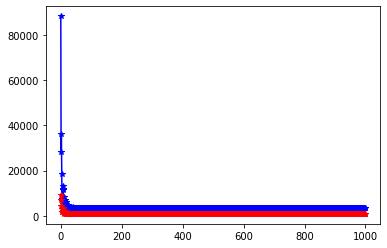

In [108]:
epochs = 1000
plt.plot(list(range(epochs)),history.history['loss'],'b*-')
plt.plot(list(range(epochs)),history.history['val_loss'],'r*-')

In [52]:
metrics_train_dvar1

{'MAE': 0.19040683770720648,
 'MAPE': 35.88878712226177,
 'median_percentile_max_error': 95.45554759245938,
 '90_percentile_max_error': 209.77616680804823,
 'r2': -1.8579849671996508e+25,
 'r2_adj': -1.8583516072200154e+25}

In [53]:
metrics_train_dvar2

{'MAE': 0.19040683770722408,
 'MAPE': 35.888787122270124,
 'median_percentile_max_error': 95.45554759268158,
 '90_percentile_max_error': 209.7761668081671,
 'r2': -6.66319340677437e+23,
 'r2_adj': -6.664508268524857e+23}

In [54]:
 metrics_train_qoi1

{'MAE': 0.15308933074074696,
 'MAPE': 24.756685691746874,
 'median_percentile_max_error': 36.109817858957456,
 '90_percentile_max_error': 68.98416210207559,
 'r2': -1.6575567070704405e+25,
 'r2_adj': -1.6694138070693548e+25}

In [55]:
metrics_val_dvar1


{'MAE': 0.19117567430728352,
 'MAPE': 35.81435175626871,
 'median_percentile_max_error': 95.45554759245938,
 '90_percentile_max_error': 209.77616680804823,
 'r2': -1.5078274607853093e+26,
 'r2_adj': -1.5090184777369565e+26}

In [56]:
metrics_val_dvar2


{'MAE': 0.19117567430730176,
 'MAPE': 35.81435175627703,
 'median_percentile_max_error': 95.4555475928024,
 '90_percentile_max_error': 209.77616680814816,
 'r2': -2.7956931826619426e+25,
 'r2_adj': -2.797901471115862e+25}

In [57]:
metrics_val_qoi1


{'MAE': 0.15697762446631408,
 'MAPE': 25.383789578107425,
 'median_percentile_max_error': 36.81028000613779,
 '90_percentile_max_error': 69.91831723773299,
 'r2': -9.049423984546342e+25,
 'r2_adj': -9.314070014963618e+25}

In [58]:
autoencoder

In [59]:
test_data

[array([[3.00000000e-01, 1.60000000e+00, 1.00000000e+00, 1.35000000e+00,
         3.15478672e-02],
        [1.00000000e-01, 1.30000000e+00, 1.00000000e+00, 1.45000000e+00,
         5.00000000e-01],
        [1.90000000e+00, 1.60000000e+00, 1.00000000e+00, 1.39000000e+00,
         5.00000000e-03],
        ...,
        [2.10000000e+00, 1.40000000e+00, 1.00000000e+00, 1.48000000e+00,
         1.99053585e-02],
        [1.00000000e-01, 1.60000000e+00, 1.00000000e+00, 1.44000000e+00,
         5.00000000e-04],
        [5.00000000e-01, 1.80000000e+00, 1.00000000e+00, 1.51000000e+00,
         1.25594322e-02]]),
 array([[0.45560169, 0.48756012, 0.53493952, ..., 0.28335847, 0.28336941,
         0.29139916],
        [0.07085483, 0.075903  , 0.0835336 , ..., 0.06311003, 0.06254692,
         0.06391667],
        [0.8806562 , 0.92198816, 0.96483224, ..., 0.75601883, 0.73204102,
         0.74859209],
        ...,
        [0.85371473, 0.90409025, 0.96346319, ..., 0.60376902, 0.5923861 ,
         0.61299

In [60]:
dvar_pred_train1 = autoencoder.predict(train_data)
dvar_pred_val1 = autoencoder.predict(val_data)
        
dvar_pred_train2 = autoencoder.decoder(qoi_train)
dvar_pred_val2 = autoencoder.decoder(qoi_val)
        
qoi_pred_train1 = autoencoder.encoder(dvar_train)
qoi_pred_val1 = autoencoder.encoder(dvar_val)


dvar_pred_train3 = autoencoder.decoder(qoi_pred_train1)
dvar_pred_val3 = autoencoder.decoder(qoi_pred_val1)


In [61]:
dvar_pred_train2 = np.array(dvar_pred_train2)
dvar_pred_val2 = np.array(dvar_pred_val2)

qoi_pred_train1 = np.array(qoi_pred_train1)
qoi_pred_val1 = np.array(qoi_pred_val1)

dvar_pred_train3 = np.array(dvar_pred_train3)
dvar_pred_val3 = np.array(dvar_pred_val3)

In [62]:
calculate_metrics(dvar_train,dvar_pred_train1,n_in = dvar_train.shape[1])

{'MAE': 0.19019430014196617,
 'MAPE': 707.1793111143833,
 'median_percentile_max_error': 710.8714293266025,
 '90_percentile_max_error': 12751.446083009454,
 'r2': -inf,
 'r2_adj': -inf}

In [63]:
calculate_metrics(dvar_pred_train1,dvar_train,n_in = dvar_train.shape[1])

{'MAE': 0.19019430014196617,
 'MAPE': 35.78526077382221,
 'median_percentile_max_error': 95.45554759245938,
 '90_percentile_max_error': 209.77616680804823,
 'r2': -1.832156244108302e+25,
 'r2_adj': -1.832517787293263e+25}

In [64]:
dvar_train

array([[0.7       , 1.4       , 1.        , 1.49      , 0.05      ],
       [1.1       , 1.4       , 1.        , 1.51      , 0.19905359],
       [0.9       , 2.        , 1.        , 1.39      , 0.19905359],
       ...,
       [1.3       , 1.3       , 1.        , 1.44      , 0.01255943],
       [0.7       , 1.2       , 1.        , 1.56      , 0.31547867],
       [1.9       , 1.3       , 1.        , 1.46      , 0.12559432]])

In [65]:
dvar_pred_train1

array([[1.0204913 , 1.63221887, 1.00302201, 1.48184746, 0.10184085],
       [1.0204913 , 1.63221887, 1.00302201, 1.48184746, 0.10184085],
       [1.0204913 , 1.63221887, 1.00302201, 1.48184746, 0.10184085],
       ...,
       [1.0204913 , 1.63221887, 1.00302201, 1.48184746, 0.10184085],
       [1.0204913 , 1.63221887, 1.00302201, 1.48184746, 0.10184085],
       [1.0204913 , 1.63221887, 1.00302201, 1.48184746, 0.10184085]])

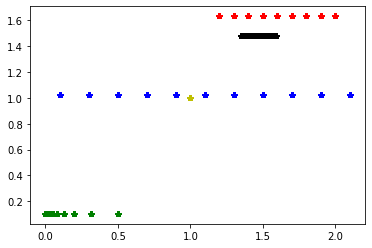

In [66]:
plt.plot(dvar_train.T[0],dvar_pred_train1.T[0],'b*')
plt.plot(dvar_train.T[1],dvar_pred_train1.T[1],'r*')
plt.plot(dvar_train.T[2],dvar_pred_train1.T[2],'y*')
plt.plot(dvar_train.T[3],dvar_pred_train1.T[3],'k*')
plt.plot(dvar_train.T[4],dvar_pred_train1.T[4],'g*')

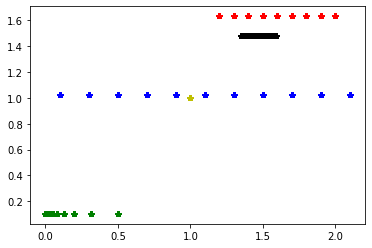

In [67]:
plt.plot(dvar_train.T[0],dvar_pred_train2.T[0],'b*')
plt.plot(dvar_train.T[1],dvar_pred_train2.T[1],'r*')
plt.plot(dvar_train.T[2],dvar_pred_train2.T[2],'y*')
plt.plot(dvar_train.T[3],dvar_pred_train2.T[3],'k*')
plt.plot(dvar_train.T[4],dvar_pred_train2.T[4],'g*')

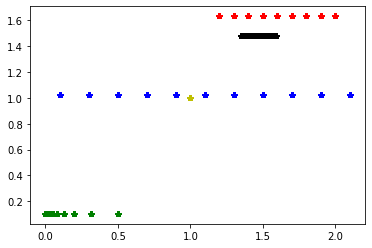

In [68]:
plt.plot(dvar_train.T[0],dvar_pred_train3.T[0],'b*')
plt.plot(dvar_train.T[1],dvar_pred_train3.T[1],'r*')
plt.plot(dvar_train.T[2],dvar_pred_train3.T[2],'y*')
plt.plot(dvar_train.T[3],dvar_pred_train3.T[3],'k*')
plt.plot(dvar_train.T[4],dvar_pred_train3.T[4],'g*')

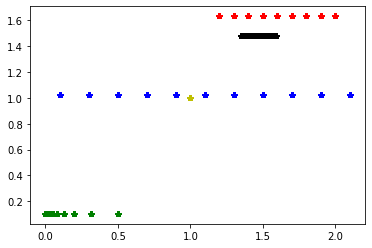

In [69]:
plt.plot(dvar_val.T[0],dvar_pred_val1.T[0],'b*')
plt.plot(dvar_val.T[1],dvar_pred_val1.T[1],'r*')
plt.plot(dvar_val.T[2],dvar_pred_val1.T[2],'y*')
plt.plot(dvar_val.T[3],dvar_pred_val1.T[3],'k*')
plt.plot(dvar_val.T[4],dvar_pred_val1.T[4],'g*')

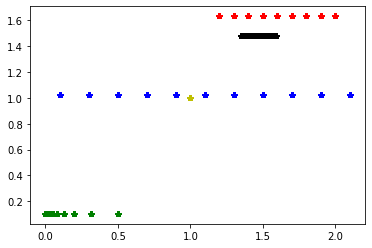

In [70]:
plt.plot(dvar_val.T[0],dvar_pred_val2.T[0],'b*')
plt.plot(dvar_val.T[1],dvar_pred_val2.T[1],'r*')
plt.plot(dvar_val.T[2],dvar_pred_val2.T[2],'y*')
plt.plot(dvar_val.T[3],dvar_pred_val2.T[3],'k*')
plt.plot(dvar_val.T[4],dvar_pred_val2.T[4],'g*')

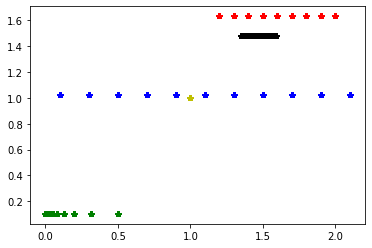

In [71]:
plt.plot(dvar_val.T[0],dvar_pred_val3.T[0],'b*')
plt.plot(dvar_val.T[1],dvar_pred_val3.T[1],'r*')
plt.plot(dvar_val.T[2],dvar_pred_val3.T[2],'y*')
plt.plot(dvar_val.T[3],dvar_pred_val3.T[3],'k*')
plt.plot(dvar_val.T[4],dvar_pred_val3.T[4],'g*')

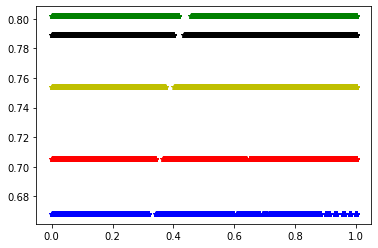

In [72]:
plt.plot(qoi_train.T[0],qoi_pred_train1.T[0],'b*')
plt.plot(qoi_train.T[1],qoi_pred_train1.T[1],'r*')
plt.plot(qoi_train.T[2],qoi_pred_train1.T[2],'y*')
plt.plot(qoi_train.T[3],qoi_pred_train1.T[3],'k*')
plt.plot(qoi_train.T[4],qoi_pred_train1.T[4],'g*')

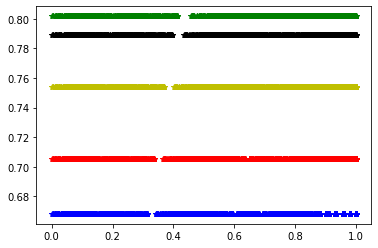

In [73]:
plt.plot(qoi_val.T[0],qoi_pred_val1.T[0],'b*')
plt.plot(qoi_val.T[1],qoi_pred_val1.T[1],'r*')
plt.plot(qoi_val.T[2],qoi_pred_val1.T[2],'y*')
plt.plot(qoi_val.T[3],qoi_pred_val1.T[3],'k*')
plt.plot(qoi_val.T[4],qoi_pred_val1.T[4],'g*')

In [74]:
mean_true = np.mean(dvar_train)
print(mean_true)
total_sum_of_squares = np.sum((dvar_train-mean_true)**2.,axis= 0)
print(total_sum_of_squares)
residual_sum_of_squares = np.sum((dvar_train-dvar_pred_train1)**2.,axis = 0)
print(residual_sum_of_squares)
r2 = 1. - residual_sum_of_squares /total_sum_of_squares
print(r2)

1.050696191041442
[10168.13084318  9376.69814949    65.13671036  4593.05196903
 24167.44844715]
[1.02631381e+04 1.70117991e+03 2.31455661e-01 1.35700763e+02
 4.79373431e+02]
[-0.00934363  0.81857367  0.99644662  0.97045521  0.9801645 ]


In [75]:
test_data

[array([[3.00000000e-01, 1.60000000e+00, 1.00000000e+00, 1.35000000e+00,
         3.15478672e-02],
        [1.00000000e-01, 1.30000000e+00, 1.00000000e+00, 1.45000000e+00,
         5.00000000e-01],
        [1.90000000e+00, 1.60000000e+00, 1.00000000e+00, 1.39000000e+00,
         5.00000000e-03],
        ...,
        [2.10000000e+00, 1.40000000e+00, 1.00000000e+00, 1.48000000e+00,
         1.99053585e-02],
        [1.00000000e-01, 1.60000000e+00, 1.00000000e+00, 1.44000000e+00,
         5.00000000e-04],
        [5.00000000e-01, 1.80000000e+00, 1.00000000e+00, 1.51000000e+00,
         1.25594322e-02]]),
 array([[0.45560169, 0.48756012, 0.53493952, ..., 0.28335847, 0.28336941,
         0.29139916],
        [0.07085483, 0.075903  , 0.0835336 , ..., 0.06311003, 0.06254692,
         0.06391667],
        [0.8806562 , 0.92198816, 0.96483224, ..., 0.75601883, 0.73204102,
         0.74859209],
        ...,
        [0.85371473, 0.90409025, 0.96346319, ..., 0.60376902, 0.5923861 ,
         0.61299

In [76]:
dvar_pred_test1= autoencoder.predict(test_data)
dvar_pred_test2 = autoencoder.decoder(qoi_test)
qoi_pred_test1 = autoencoder.encoder(dvar_test)

Tensor("IteratorGetNext:0", shape=(None, 5), dtype=float64)


In [77]:
test_data

[array([[3.00000000e-01, 1.60000000e+00, 1.00000000e+00, 1.35000000e+00,
         3.15478672e-02],
        [1.00000000e-01, 1.30000000e+00, 1.00000000e+00, 1.45000000e+00,
         5.00000000e-01],
        [1.90000000e+00, 1.60000000e+00, 1.00000000e+00, 1.39000000e+00,
         5.00000000e-03],
        ...,
        [2.10000000e+00, 1.40000000e+00, 1.00000000e+00, 1.48000000e+00,
         1.99053585e-02],
        [1.00000000e-01, 1.60000000e+00, 1.00000000e+00, 1.44000000e+00,
         5.00000000e-04],
        [5.00000000e-01, 1.80000000e+00, 1.00000000e+00, 1.51000000e+00,
         1.25594322e-02]]),
 array([[0.45560169, 0.48756012, 0.53493952, ..., 0.28335847, 0.28336941,
         0.29139916],
        [0.07085483, 0.075903  , 0.0835336 , ..., 0.06311003, 0.06254692,
         0.06391667],
        [0.8806562 , 0.92198816, 0.96483224, ..., 0.75601883, 0.73204102,
         0.74859209],
        ...,
        [0.85371473, 0.90409025, 0.96346319, ..., 0.60376902, 0.5923861 ,
         0.61299

In [78]:
qoi_pred_test1

<tf.Tensor: shape=(7920, 180), dtype=float64, numpy=
array([[0.66812889, 0.70516049, 0.75380154, ..., 0.52642932, 0.52069018,
        0.53087701],
       [0.66812889, 0.70516049, 0.75380154, ..., 0.52642932, 0.52069018,
        0.53087701],
       [0.66812889, 0.70516049, 0.75380154, ..., 0.52642932, 0.52069018,
        0.53087701],
       ...,
       [0.66812889, 0.70516049, 0.75380154, ..., 0.52642932, 0.52069018,
        0.53087701],
       [0.66812889, 0.70516049, 0.75380154, ..., 0.52642932, 0.52069018,
        0.53087701],
       [0.66812889, 0.70516049, 0.75380154, ..., 0.52642932, 0.52069018,
        0.53087701]])>

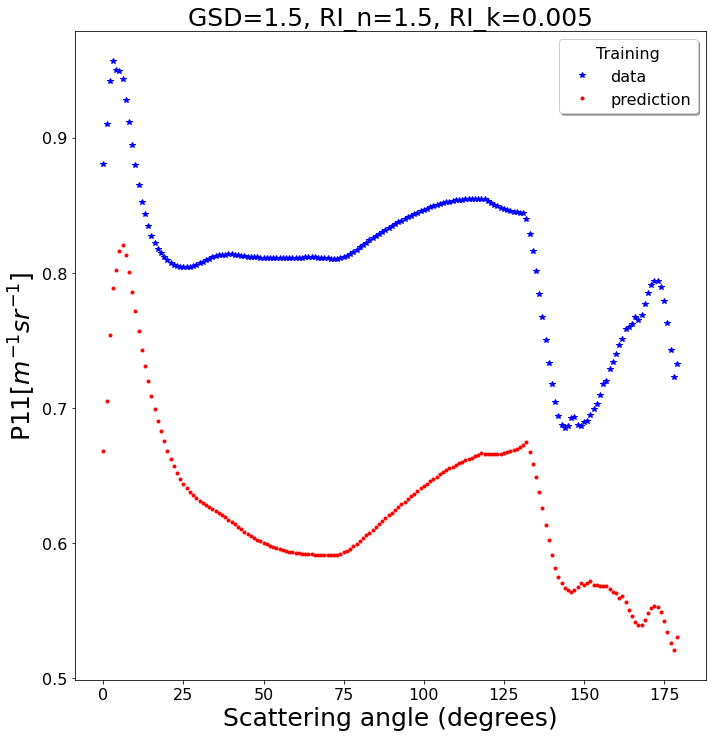

In [79]:
presentation_plot_index = [3]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(np.array(qoi_train)[0])),np.array(qoi_train)[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_train1[0])), qoi_pred_train1[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='Training', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

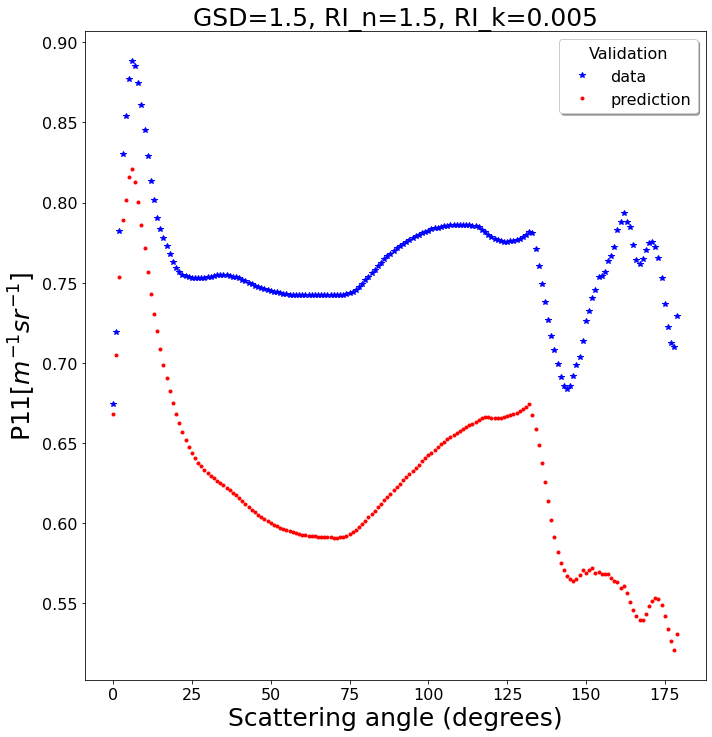

In [80]:
presentation_plot_index = [3]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(np.array(qoi_val)[0])),np.array(qoi_val)[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_val1[0])), qoi_pred_val1[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='Validation', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

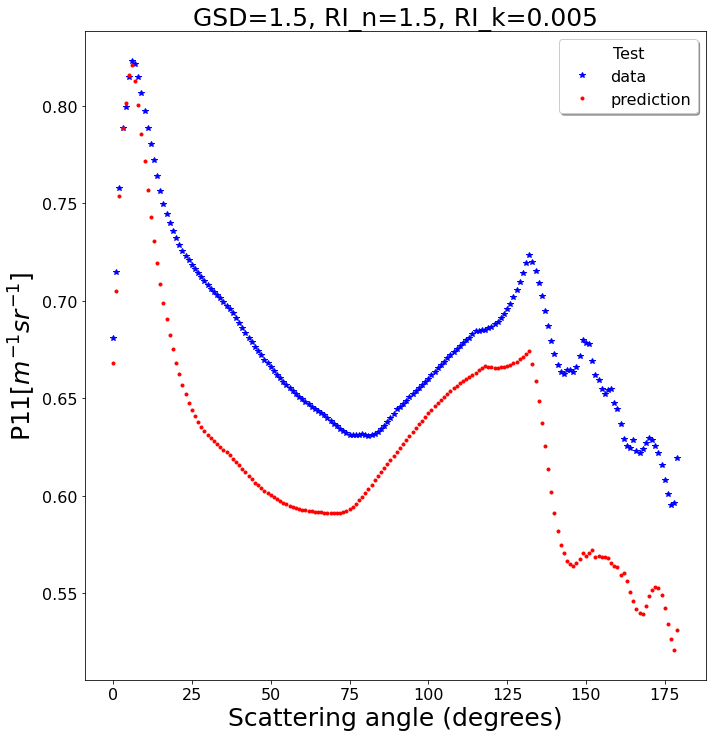

In [81]:
presentation_plot_index = [3]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(np.array(qoi_test)[0])),np.array(qoi_test)[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_test1[0])), qoi_pred_test1[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='Test', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')